In [165]:
import os
import pandas as pd
import numpy as np
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchmetrics import Accuracy, F1Score
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)
RAW_DATASET_DIR = "raw_datasets/SST_2"

In [166]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")
device

device(type='cuda')

In [167]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
df

,0,1
0,"a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films",1
1,apparently reassembled from the cutting room floor of any given daytime soap,0
2,"they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes",0
3,"this is a visually stunning rumination on love , memory , history and the war between art and commerce",1
4,jonathan parker 's bartleby should have been the be all end all of the modern office anomie films,1
...,...,...
6915,"painful , horrifying and oppressively tragic , this film should not be missed",1
6916,"take care is nicely performed by a quintet of actresses , but nonetheless it drags during its 112 minute length",0
6917,"the script covers huge , heavy topics in a bland , surfacey way that does n't offer any insight into why , for instance , good things happen to bad people",0
6918,a seriously bad film with seriously warped logic by writer director kurt wimmer at the screenplay level,0


In [168]:
df_train = pd.read_csv(os.path.join(RAW_DATASET_DIR, "train" + ".tsv"), delimiter='\t')
df_dev = pd.read_csv(os.path.join(RAW_DATASET_DIR, "dev" + ".tsv"), delimiter='\t')
df_test = pd.read_csv(os.path.join(RAW_DATASET_DIR, "test" + ".tsv"), delimiter='\t')

print(len(df_train), len(df_dev), len(df_test))
df_train

67349 872 1821


,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals it sets for itself",1
67347,a patient viewer,1


In [169]:
df_train

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals it sets for itself",1
67347,a patient viewer,1


In [170]:
df_train.loc[df_train[df_train.label == 1].index.repeat(2)].reset_index(drop=True)

,sentence,label
0,that loves its characters and communicates something rather beautiful about human nature,1
1,that loves its characters and communicates something rather beautiful about human nature,1
2,"demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .",1
3,"demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .",1
4,of saucy,1
...,...,...
75133,a delightful comedy,1
75134,"at achieving the modest , crowd-pleasing goals it sets for itself",1
75135,"at achieving the modest , crowd-pleasing goals it sets for itself",1
75136,a patient viewer,1


In [5]:
max(df_test.apply(lambda x: len(x["sentence"].split()), axis=1))

56

In [6]:
text = df.iloc[110,0]
print(text)
print(len(text.split()))

its spirit of iconoclastic abandon however canned makes for unexpectedly giddy viewing
12


### Word piece tokenizer

In [174]:
bert_model_name = "bert-large-uncased"

In [175]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

sequence = "A Titan RTX has 24GB of VRAM"

In [176]:
tokenized_sequence = tokenizer.tokenize(sequence)
print(tokenized_sequence)

['a', 'titan', 'rt', '##x', 'has', '24', '##gb', 'of', 'vr', '##am']


In [177]:
encoded_sequence = tokenizer(sequence)["input_ids"]
print(encoded_sequence)

[101, 1037, 16537, 19387, 2595, 2038, 2484, 18259, 1997, 27830, 3286, 102]


In [178]:
decoded_sequence = tokenizer.decode(encoded_sequence)
print(decoded_sequence)

[CLS] a titan rtx has 24gb of vram [SEP]


In [179]:
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)
op = tokenizer.encode_plus(
             text, # text
            df.iloc[211,0], # text pair
            apad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=56,
        )
op

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'apad_to_max_length': True} not recognized.
Keyword arguments {'apad_to_max_length': True} not recognized.


{'input_ids': [101, 2049, 4382, 1997, 12696, 10085, 28723, 10824, 2174, 27141, 3084, 2005, 14153, 21025, 14968, 10523, 102, 2331, 2000, 15488, 9541, 11714, 4136, 1037, 18282, 2100, 2214, 2666, 1010, 2025, 3053, 2004, 11808, 2004, 2009, 6732, 2009, 2003, 8257, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [180]:
tokenizer.decode(op["input_ids"])

'[CLS] its spirit of iconoclastic abandon however canned makes for unexpectedly giddy viewing [SEP] death to smoochy tells a moldy oldie, not nearly as nasty as it thinks it is joke [SEP]'

### Dataloader

In [171]:
class BertDataset(Dataset):
    def __init__(self, tokenizer,max_length, device=torch.device("cuda"), split="train"):
        super(BertDataset, self).__init__()
        self.data_df=pd.read_csv(os.path.join(RAW_DATASET_DIR, split + ".tsv"), delimiter='\t')
        self.tokenizer=tokenizer
        self.target=self.data_df.iloc[:,1]
        self.max_length=max_length
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        
        text1 = self.data_df.iloc[index,0].lower()
        
        inputs = self.tokenizer.encode_plus(
            text1 ,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long).to(device),
            'mask': torch.tensor(mask, dtype=torch.long).to(device),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long).to(device),
            'target': torch.tensor(self.data_df.iloc[index, 1], dtype=torch.long).to(device)
            }

In [181]:
bert_model_name

'bert-large-uncased'

In [172]:
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)
BATCH_SIZE = 32
MAX_SENT_LENGTH = 56

# train dataset
train_dataset= BertDataset(tokenizer, max_length=MAX_SENT_LENGTH, split="train")
train_dataloader=DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE)
print(len(train_dataset), len(train_dataloader))

# dev dataset
dev_dataset= BertDataset(tokenizer, max_length=MAX_SENT_LENGTH, split="dev")
dev_dataloader=DataLoader(dataset=dev_dataset,batch_size=BATCH_SIZE)
print(len(dev_dataset), len(dev_dataloader))

# test dataset
test_dataset= BertDataset(tokenizer, max_length=MAX_SENT_LENGTH, split="test")
test_dataloader=DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE)
print(len(test_dataset), len(test_dataloader))

OSError: bert-large-uncased_SST2_3_5e-05_FULL.pt is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [153]:
# testing data loaders
next(iter(train_dataloader));

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/karm/miniconda3/envs/torch310/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [154]:
class BERT(nn.Module):
    def __init__(self,d_model=768, H = 50, n_classes=2):
        super(BERT, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, n_classes)
        )
        
    def forward(self,ids,mask,token_type_ids):
        # need to pass positional embeddings
        last_hidden_states, cls = self.bert_model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
        # last_hidden_state.shape = (batch_size, sequence_length, hidden_size)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = last_hidden_states[:, 0, :] # (Batch, MAX_length, hidden_size)
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [155]:
# class BERT(nn.Module):
#     def __init__(self):
#         super(BERT, self).__init__()
#         self.bert_model = transformers.BertModel.from_pretrained("bert-base-uncased")
#         self.out = nn.Linear(768, 2)
        
        
#     def forward(self,ids,mask,token_type_ids):
#         # need to pass positional embeddings
#         last_hidden_states, cls = self.bert_model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
#         # last_hidden_state.shape = (batch_size, sequence_length, hidden_size)
#         # cls = (batch_size , hidden_size) -- need to check this, is this original cls or it's passed to liner layer
#         out= self.out(cls)
#         out = F.log_softmax(out, dim=1)
# #         print(out.shape)
#         return out

In [156]:
# nn.CrossEntropyLoss()

In [158]:
model=BERT(d_model=1024, H = 100).to(device)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()

#Initialize Optimizer
lr = 5e-5
optimizer= optim.Adam(model.parameters(),lr= lr)

In [159]:
# # only finetune classification head
# for param in model.bert_model.parameters():
#     param.requires_grad = False

In [160]:
epochs = 3
train_losses = []

for epoch in range(epochs):
    model.train()
    loop=tqdm(enumerate(train_dataloader),leave=False,total=len(train_dataloader))
    print(epoch)
    total_matches = 0
    for batch, dl in loop:
        ids, token_type_ids, mask, label = dl['ids'], dl['token_type_ids'], dl['mask'], dl['target']

#         label = label.unsqueeze(1) # 1D to 2D ex: (B,) -> (B, 1)
        optimizer.zero_grad()

        output=F.softmax(model(ids=ids,mask=mask,token_type_ids=token_type_ids), dim=1) # (B, 2)

        loss=loss_fn(output,label)
        loss.backward()
#         print(loss)
        train_losses.append(loss)

        optimizer.step()
        pred = torch.argmax(output, dim=-1) # (B,1)
        accuracy = Accuracy(task = "binary").to(device)(pred, label)
        total_matches += (torch.sum(pred == label)).item()

        # Show progress while training
        loop.set_description_str(f"Epoch={epoch}/{epochs} loss={loss.item()} acc={accuracy}")

    
    print(f"Train Accuracy :{epoch} = {total_matches/len(train_dataset)}") 

  0%|          | 0/2105 [00:00<?, ?it/s]

0


Train Accuracy :0 = 0.5862893287205452


  0%|          | 0/2105 [00:00<?, ?it/s]

1


Train Accuracy :1 = 0.5578108063965315


  0%|          | 0/2105 [00:00<?, ?it/s]

2


Train Accuracy :2 = 0.5571871891193633


In [161]:
# save model
model_name = f"{model_name}_SST2_{epochs}_{lr}_FULL.pt"
torch.save(model.state_dict(), f"ckpts/{model_name}")

In [162]:
# dev dataset
dev_losses = []

model.eval()
loop=tqdm(enumerate(dev_dataloader),leave=False,total=len(dev_dataloader))
total_matches = 0
with torch.no_grad():
    for batch, dl in loop:
        ids, token_type_ids, mask, label = dl['ids'], dl['token_type_ids'], dl['mask'], dl['target']
        output=F.softmax(model(ids=ids,mask=mask,token_type_ids=token_type_ids), dim=1)
#         label = label.type_as(output)
        loss=loss_fn(output,label)
        dev_losses.append(loss)

        pred = torch.argmax(output, dim=-1)

        matches = torch.sum(pred == label)
        total_matches += matches.item()

        # Show progress while training
        loop.set_description(f'loss={loss.item()}')


    print(f"Validation Accuracy :{total_matches/len(dev_dataset)}")    

Validation Accuracy :0.5091743119266054


## Custom Sentences

In [59]:
class BertCustomDataset(Dataset):
    def __init__(self, tokenizer, max_length, sentences, device=torch.device("cuda")):
        super(BertCustomDataset, self).__init__()
        self.data_df=pd.DataFrame(custom_sentences, columns=["text"])
        self.tokenizer=tokenizer
#         self.target=self.data_df.iloc[:,1]
        self.max_length=max_length
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        
        text1 = self.data_df.iloc[index,0]
        
        inputs = self.tokenizer.encode_plus(
            text1 ,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long).to(device),
            'mask': torch.tensor(mask, dtype=torch.long).to(device),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long).to(device),
            }

In [102]:
custom_sentences = ["I do not like food there.", "I like these mangoes", "You made 1 run in only 50 balls", "Opps! You made 1 run in only 50 balls", "Wow! You made 1 run in only 50 balls", "You made only 1 run in 50 balls", "Opps! You made only 1 run in 50 balls", "Wow! You made only 1 run in 50 balls"]
custom_sentences = ["You made 100 run in only 50 balls", "You made only 1 run in 50 balls", "Wow! You made only 1 run in 50 balls", "Despite being a topper you are just passed", "Despite being a back bencher you are passed"]

custom_dataset = BertCustomDataset(tokenizer, 56, custom_sentences)
custom_dataloader = DataLoader(custom_dataset, batch_size=len(custom_sentences))
model.eval()
with torch.no_grad():
    data = next(iter(custom_dataloader))
    ids, token_type_ids, mask = data['ids'], data['token_type_ids'], data['mask']
    output=F.softmax(model(ids=ids,mask=mask,token_type_ids=token_type_ids), dim=1)
#     print("Prediction:")
#     print(list(zip(custom_sentences, torch.argmax(output, dim=1))))
    
df = pd.DataFrame(custom_sentences, columns=["input"])
df["Prediction"] = torch.argmax(output, dim=-1).to(cpu_device)
df["Prediction"] = df["Prediction"].apply(lambda x: {0: "Negative", 1: "Positive"}[x])
df["Probability"] = torch.max(output, dim=-1).values.to(cpu_device)
df

/home/karm/miniconda3/envs/torch310/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,input,Prediction,Probability
0,You made 100 run in only 50 balls,Negative,0.999990
1,You made only 1 run in 50 balls,Negative,0.999993
2,Wow! You made only 1 run in 50 balls,Negative,0.667920
3,Despite being a topper you are just passed,Negative,0.581516
4,Despite being a back bencher you are passed,Positive,0.999947


,text,Prediction,Probability
0,I do not like food there.,0,0.999993
1,I like these mangoes,1,0.999988
2,Opps! You made 1 runs in only 50 balls,0,0.999992
3,Wow! You made only 1 run in 50 balls,0,0.667919


In [235]:
print(accuracy)

tensor(0.8571, device='cuda:0')


In [24]:
import matplotlib.pyplot as plt
cpu_device = torch.device("cpu")

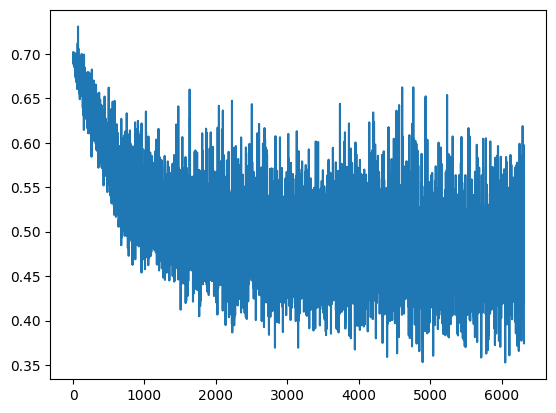

In [25]:
plt.plot(torch.tensor(train_losses).to(cpu_device))

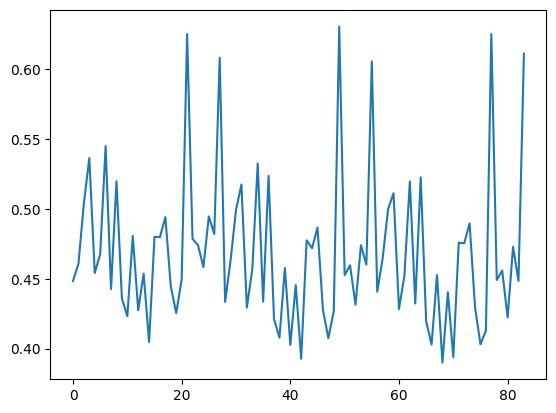

In [26]:
plt.plot(torch.tensor(dev_losses).to(cpu_device))

### Extras

In [ ]:
model.train()
epochs = 3

loop=tqdm(enumerate(train_dataloader),leave=False,total=len(train_dataloader))
train_losses = []
dev_losses = []
for epoch in range(epochs):
    print(epoch)
    for batch, dl in loop:
        ids, token_type_ids, mask, label = dl['ids'], dl['token_type_ids'], dl['mask'], dl['target']

        label = label.unsqueeze(1) # 1D to 2D ex: (B,) -> (B, 1)
        optimizer.zero_grad()

        output=model(ids=ids,mask=mask,token_type_ids=token_type_ids)
        label = label.type_as(output)

        loss=loss_fn(output,label)
        loss.backward()
        train_losses.append(loss)

        optimizer.step()
        pred = torch.where(output >= 0, 1, 0)

        accuracy = Accuracy(task = "binary").to(device)(pred, label)

        # Show progress while training
        loop.set_description(f'Epoch={epoch}/{epochs}')
        loop.set_postfix(loss=loss.item(),acc=accuracy)
    


In [ ]:
# dev dataset
loop=tqdm(enumerate(dev_dataloader),leave=False,total=len(dev_dataloader))
total_matches = 0
with torch.no_grad():
    for batch, dl in loop:
        ids, token_type_ids, mask, label = dl['ids'], dl['token_type_ids'], dl['mask'], dl['target']

        label = label.unsqueeze(1) # 1D to 2D ex: (B,) -> (B, 1)
#         optimizer.zero_grad()

        output=model(ids=ids,mask=mask,token_type_ids=token_type_ids)
        label = label.type_as(output)

        loss=loss_fn(output,label)
#         loss.backward()
        dev_losses.append(loss)

#         optimizer.step()
        pred = torch.where(output >= 0, 1, 0)

        matches = torch.sum(pred == label)
        total_matches += matches.item()

        # Show progress while training
        loop.set_description(f'Epoch={epoch}/{epochs}')
        loop.set_postfix(loss=loss.item(),acc=accuracy)


    print(f"Validation Accuracy :{epoch} - {total_matches/len(dev_dataset)}")    

In [145]:
model.train()
epochs = epoch = 1
loop=tqdm(enumerate(dev_dataloader),leave=False,total=len(dev_dataloader))

losses = torch.tensor([0]*len(dev_dataloader))
total_matches = 0
for batch, dl in loop:
    ids, token_type_ids, mask, label = dl['ids'], dl['token_type_ids'], dl['mask'], dl['target']

    label = label.unsqueeze(1) # 1D to 2D ex: (B,) -> (B, 1)
    optimizer.zero_grad()

    output=model(ids=ids,mask=mask,token_type_ids=token_type_ids)
    label = label.type_as(output)

    loss=loss_fn(output,label)
    loss.backward()
    losses[batch] = loss

    optimizer.step()
    pred = torch.where(output >= 0, 1, 0)

    matches = torch.sum(pred == label)
    total_matches += matches.item()

    # Show progress while training
    loop.set_description(f'Epoch={epoch}/{epochs}')
    loop.set_postfix(loss=loss.item(),acc=accuracy)

print(total_matches/len(dev_dataset))

  0%|          | 0/14 [00:00<?, ?it/s]/home/karm/miniconda3/envs/torch310/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
                                                                                                           

0.5538990825688074


In [146]:
torch.mean(loss)

tensor(0.6917, device='cuda:0', grad_fn=<MeanBackward0>)

In [137]:
Accuracy(task="binary").to(device)(pred, label)

tensor(0.4219, device='cuda:0')

In [131]:
label.dtype

torch.float32

In [ ]:
acc_obj.

In [27]:
def finetune(epochs,dataloader,model,loss_fn,optimizer):
    model.train()
    for epoch in range(epochs):
        print(epoch)
        
        loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
        for batch, dl in loop:
            ids=dl['ids']
            token_type_ids=dl['token_type_ids']
            mask= dl['mask']
            label=dl['target']
            label = label.unsqueeze(1)
            
            optimizer.zero_grad()
            
            output=model(ids=ids,mask=mask,token_type_ids=token_type_ids)
            label = label.type_as(output)

            loss=loss_fn(output,label)
            loss.backward()
            
            optimizer.step()
            pred = torch.where(output >= 0, 1, 0)
            

            num_correct = sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            num_samples = pred.shape[0]
            accuracy = num_correct/num_samples
            
            
            # Show progress while training
            loop.set_description(f'Epoch={epoch}/{epochs}')
            loop.set_postfix(loss=loss.item(),acc=accuracy)
    
    return model

  0%|          | 0/1053 [00:00<?, ?it/s]/home/karm/miniconda3/envs/torch310/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0


KeyboardInterrupt: 

In [29]:
model=finetune(5, dataloader, model, loss_fn, optimizer)